In [1]:
# import os
# from glob import glob
# from tqdm.notebook import tqdm
# from sklearn.model_selection import train_test_split

# CONTENT_PATH = os.path.join("/home/jupyter/style-transfer/data/ffhq-256/")
# STYLE_PATH = os.path.join("/home/jupyter/style-transfer/data/celeb_cartoons/")

# content_images = glob(CONTENT_PATH + '*.jpg')
# style_images = glob(STYLE_PATH + '*.png')

# content_train, content_test = train_test_split(content_images, test_size=0.1, random_state=42)
# style_train, style_test = train_test_split(style_images, test_size=0.1, random_state=42)

# def copy_images(paths, split):
#     for f in tqdm(paths):
#         save_path = f.replace(" ", "_")
#         f = f'"{f}"'
#         save_path = save_path.replace('celeb_cartoons', f'cyclegan/{split}')
#         save_path = save_path.replace('ffhq-256', f'cyclegan/{split}')
#         _ = os.system(f"cp {f} {save_path}")

# copy_images(content_train, 'trainA')
# copy_images(style_train, 'trainB')
# copy_images(content_test, 'testA')
# copy_images(style_test, 'testB')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
 
import os
import time
import datetime
 
from matplotlib import pyplot as plt
from IPython import display

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    
    image = normalize(image)
    return image

In [5]:
PATH = os.path.join("/home/jupyter/style-transfer/data/cyclegan/")

# apply the above load_images_train function on train data
train_content = tf.data.Dataset.list_files(PATH + 'trainA/*.jpg')
train_content = train_content.map(preprocess_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_style = tf.data.Dataset.list_files(PATH + 'trainB/*.png')
train_style = train_style.map(preprocess_image_train,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# apply the above load_images_test function on test data
test_content = tf.data.Dataset.list_files(PATH + 'testA/*.jpg')
test_content = test_content.map(preprocess_image_test).batch(BATCH_SIZE)

test_style = tf.data.Dataset.list_files(PATH + 'testB/*.png')
test_style = test_style.map(preprocess_image_test).batch(BATCH_SIZE)

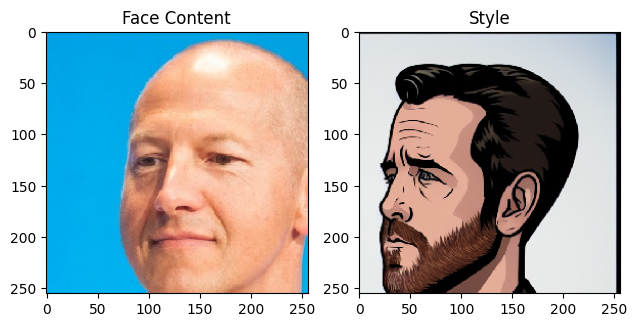

In [6]:
sample_content = next(iter(train_content))
sample_style = next(iter(train_style))

plt.subplot(121)
plt.title('Face Content')
plt.imshow(sample_content[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Style')
plt.imshow(sample_style[0] * 0.5 + 0.5)

plt.tight_layout()
plt.show()

In [7]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
    """Downsamples an input.
  
    Conv2D => Batchnorm => LeakyRelu
  
    Args:
      filters: number of filters
      size: filter size
      norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
      apply_norm: If True, adds the batchnorm layer
  
    Returns:
      Downsample Sequential Model
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        if norm_type.lower() == 'batchnorm':
            result.add(tf.keras.layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            result.add(InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.
  
    Conv2DTranspose => Batchnorm => Dropout => Relu
  
    Args:
      filters: number of filters
      size: filter size
      norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
      apply_dropout: If True, adds the dropout layer
  
    Returns:
      Upsample Sequential Model
    """

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [8]:
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [9]:
def unet_generator(output_channels, norm_type='batchnorm'):
    """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  
    Args:
      output_channels: Output channels
      norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  
    Returns:
      Generator model
    """

    down_stack = [
        downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
        downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
        downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
        downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
        downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
        downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
        downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
        downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
        upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
        upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
        upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 4, strides=2,
        padding='same', kernel_initializer=initializer,
        activation='tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
def discriminator(norm_type='batchnorm', target=True):
    """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  
    Args:
      norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
      target: Bool, indicating whether target image is an input or not.
  
    Returns:
      Discriminator model
    """

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    x = inp

    if target:
        tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
        x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    if norm_type.lower() == 'batchnorm':
        norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'instancenorm':
        norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    if target:
        return tf.keras.Model(inputs=[inp, tar], outputs=last)
    else:
        return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [12]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [13]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [14]:
checkpoint_path = "/home/jupyter/model_ckpts/celeb_cartoons/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [15]:
EPOCHS = 200

def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(8, 4))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [16]:
log_dir="/home/jupyter/tf_logs/celeb_cartoons/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [17]:
@tf.function
def train_step(real_x, real_y, epoch):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                          generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                              discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_g_loss', gen_g_loss, step=epoch)
        tf.summary.scalar('gen_f_loss', gen_f_loss, step=epoch)
        tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=epoch)
        tf.summary.scalar('total_gen_g_loss', total_gen_g_loss, step=epoch)
        tf.summary.scalar('total_gen_f_loss', total_gen_f_loss, step=epoch)
        tf.summary.scalar('disc_x_loss', disc_x_loss, step=epoch)
    tf.summary.scalar('disc_y_loss', disc_y_loss, step=epoch)

In [18]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [19]:
from IPython.display import clear_output

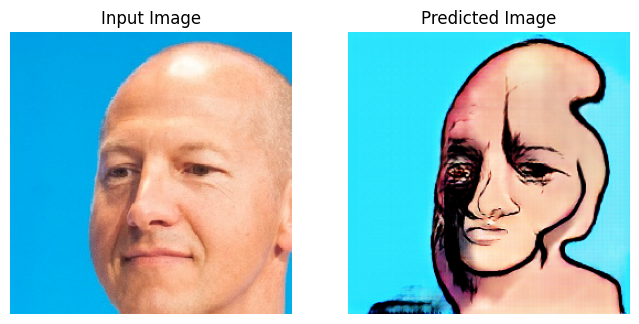

Time taken for epoch 151 is 229.38028287887573 sec

..............................

KeyboardInterrupt: 

In [20]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_content, train_style)):
        train_step(image_x, image_y, epoch)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_content) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_content)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                       time.time() - start))

In [22]:
ls {checkpoint_path}

checkpoint                   ckpt-28.index
ckpt-26.data-00000-of-00001  ckpt-29.data-00000-of-00001
ckpt-26.index                ckpt-29.index
ckpt-27.data-00000-of-00001  ckpt-30.data-00000-of-00001
ckpt-27.index                ckpt-30.index
ckpt-28.data-00000-of-00001


In [24]:
# Restoring the latest checkpoint in checkpoint_dir
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))

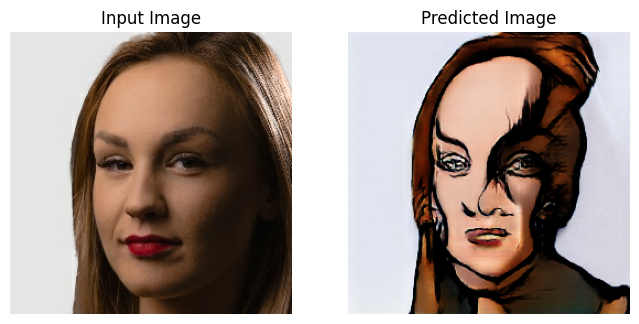

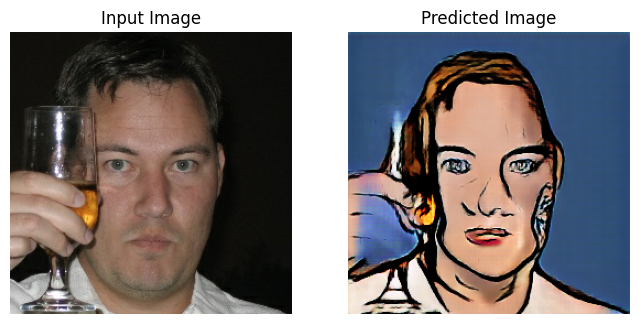

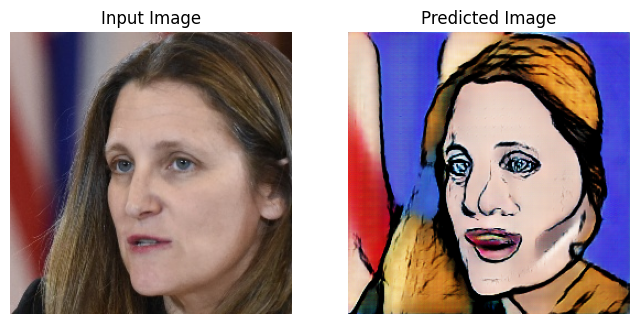

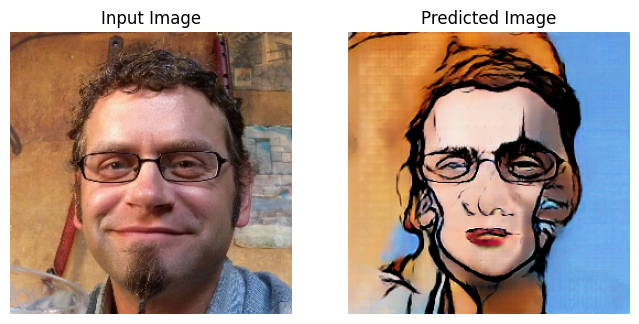

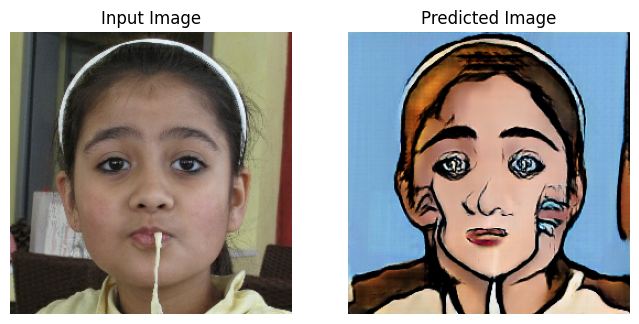

In [28]:
# Run the trained model on a few examples from the test set
for inp in test_content.take(5):
    generate_images(generator_g, inp)

In [34]:
sample_content = preprocess_image_test("/home/jupyter/style-transfer/data/sample/hp2.jpg")
sample_content = tf.expand_dims(sample_content, axis=0)
sample_content.shape

TensorShape([1, 3616, 3616, 3])

In [35]:
inp.shape

TensorShape([1, 256, 256, 3])

In [38]:
generator_g.save("/home/jupyter/style-transfer/saved_models/celeb_comics_cyclegan/celeb_comics_cyclegan.keras")

In [9]:
from tqdm.notebook import tqdm

In [10]:
len(train_content)

63000

In [11]:
i = 0
pbar = tqdm(total=len(train_content))
for image_x, image_y in tf.data.Dataset.zip((train_content, train_style.repeat())):
    i += 1
    pbar.update()

print(i)

  0%|          | 0/63000 [00:00<?, ?it/s]

63000
